<a href="https://colab.research.google.com/github/fatemafaria142/Skin-Type-Classification/blob/main/Skin_Type_Classification_Using_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Unzip a zip file in Google Colab**

In [2]:
'''
# Import the ZipFile class from the zipfile module
from zipfile import ZipFile

# Specify the path to the zip file
zip_file_path = '/content/drive/MyDrive/Skin Type Classification Dataset.zip'

# Specify the extraction directory
extract_dir = '/content/drive/MyDrive/'

# Create a ZipFile object
with ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of zip file in current directory
    zip_ref.extractall(extract_dir)

# Print a message indicating successful extraction
print(f"Zip file '{zip_file_path}' has been successfully extracted to '{extract_dir}'.")
'''

Zip file '/content/drive/MyDrive/Skin Type Classification Dataset.zip' has been successfully extracted to '/content/drive/MyDrive/'.


In [166]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, jaccard_score
import numpy as np
import os
from PIL import Image
from shutil import copyfile  # Import the copyfile function
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# **Dataset Describtion**
* train - 70%
* test - 15%
* validation - 15%

In [122]:
# Define the paths to our train, validation, and test datasets
train_data_dir = '/content/drive/MyDrive/Skin Type Classification Dataset/train'
test_data_dir = '/content/drive/MyDrive/Skin Type Classification Dataset/test'
validation_data_dir = '/content/drive/MyDrive/Skin Type Classification Dataset/validation'


In [123]:
# Image dimensions
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)  # RGB images
batch_size = 8

# **Data generators**

In [124]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255,          # scales the pixel values of the images to the range [0, 1]
    rotation_range=20,       # Rotate the image by a maximum of 20 degrees
    width_shift_range=0.2,   # Shift the image horizontally by a maximum of 20% of the width
    height_shift_range=0.2,  # Shift the image vertically by a maximum of 20% of the height
    shear_range=0.2,         # Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    zoom_range=0.2,          # Randomly zoom the image by a maximum of 20%
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest'      # Fill mode for points outside the input boundaries
)

test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Creating data generators with data augmentation
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No need to shuffle test data
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


Found 383 images belonging to 5 classes.
Found 69 images belonging to 5 classes.
Found 70 images belonging to 5 classes.


## **'Aging Skin': 0, 'Dry Skin': 1, 'Normal Skin': 2, 'Oily Skin': 3, 'Sensitive Skin': 4**

In [125]:
class_indices = train_generator.class_indices
print(class_indices)

{'Aging Skin': 0, 'Dry Skin': 1, 'Normal Skin': 2, 'Oily Skin': 3, 'Sensitive Skin': 4}


# **number of images for each class in the training dataset**

In [126]:
# Count the number of images for each class in the training dataset
classes = os.listdir(train_data_dir)
for class_name in classes:
    class_path = os.path.join(train_data_dir, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class: {class_name}, Number of images: {num_images}")


Class: Aging Skin, Number of images: 80
Class: Dry Skin, Number of images: 80
Class: Normal Skin, Number of images: 80
Class: Oily Skin, Number of images: 63
Class: Sensitive Skin, Number of images: 80


In [127]:
# List the classes in the directory
classes = os.listdir(train_data_dir)

# Iterate through each class to check image shapes
for class_name in classes:
    class_path = os.path.join(train_data_dir, class_name)
    image_files = os.listdir(class_path)

    # Check shape for a few images in each class
    for img_file in image_files[:5]:  # Checking the first 5 images
        img_path = os.path.join(class_path, img_file)
        img = Image.open(img_path)
        width, height = img.size
        channels = 1 if img.mode == 'L' else 3  # 1 for grayscale, 3 for RGB
        print(f"Class: {class_name}, Image file: {img_file}, Shape: {width}x{height}x{channels}")

Class: Aging Skin, Image file: image_1.jpg, Shape: 2500x1750x3
Class: Aging Skin, Image file: image_10.jpg, Shape: 273x184x3
Class: Aging Skin, Image file: image_11.jpg, Shape: 276x183x3
Class: Aging Skin, Image file: image_12.jpg, Shape: 225x225x3
Class: Aging Skin, Image file: image_13.jpg, Shape: 295x171x3
Class: Dry Skin, Image file: image_1.jpg, Shape: 590x393x3
Class: Dry Skin, Image file: image_10.jpg, Shape: 550x309x3
Class: Dry Skin, Image file: image_11.jpg, Shape: 275x183x3
Class: Dry Skin, Image file: image_12.jpg, Shape: 4320x3240x3
Class: Dry Skin, Image file: image_13.jpg, Shape: 288x503x3
Class: Normal Skin, Image file: image_1.jpeg, Shape: 720x960x3
Class: Normal Skin, Image file: image_10.jpg, Shape: 275x183x3
Class: Normal Skin, Image file: image_11.jpg, Shape: 183x275x3
Class: Normal Skin, Image file: image_12.jpg, Shape: 600x1098x3
Class: Normal Skin, Image file: image_13.jpg, Shape: 681x1024x3
Class: Oily Skin, Image file: image_1.jpg, Shape: 640x400x3
Class: Oily

# **Check the shape of the images in Train Generator**

In [128]:
# Get a batch of images and labels from the train_generator
batch = train_generator.next()

# Iterate through the batch to check image shapes
for i in range(len(batch[0])):
    img = batch[0][i]  # Image data
    label = batch[1][i]  # Image label

    # Get image shape and channels
    height, width, channels = img.shape

    # Display image shape and channels
    print(f"Image {i+1} - Shape: {width}x{height}x{channels}, Label: {label}")


Image 1 - Shape: 224x224x3, Label: [0. 0. 1. 0. 0.]
Image 2 - Shape: 224x224x3, Label: [1. 0. 0. 0. 0.]
Image 3 - Shape: 224x224x3, Label: [0. 0. 0. 1. 0.]
Image 4 - Shape: 224x224x3, Label: [0. 0. 0. 1. 0.]
Image 5 - Shape: 224x224x3, Label: [1. 0. 0. 0. 0.]
Image 6 - Shape: 224x224x3, Label: [0. 0. 0. 1. 0.]
Image 7 - Shape: 224x224x3, Label: [0. 1. 0. 0. 0.]
Image 8 - Shape: 224x224x3, Label: [0. 0. 1. 0. 0.]


# **number of images for each class in the testing dataset**

In [129]:
# Count the number of images for each class in the testing dataset
classes = os.listdir(test_data_dir)
for class_name in classes:
    class_path = os.path.join(test_data_dir, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class: {class_name}, Number of images: {num_images}")


Class: Aging Skin, Number of images: 15
Class: Dry Skin, Number of images: 14
Class: Normal Skin, Number of images: 15
Class: Oily Skin, Number of images: 10
Class: Sensitive Skin, Number of images: 15


In [131]:
# List the classes in the directory
classes = os.listdir(test_data_dir)

# Iterate through each class to check image shapes
for class_name in classes:
    class_path = os.path.join(test_data_dir, class_name)
    image_files = os.listdir(class_path)

    # Check shape for a few images in each class
    for img_file in image_files[:5]:  # Checking the first 5 images
        img_path = os.path.join(class_path, img_file)
        img = Image.open(img_path)
        width, height = img.size
        channels = 1 if img.mode == 'L' else 3  # 1 for grayscale, 3 for RGB
        print(f"Class: {class_name}, Image file: {img_file}, Shape: {width}x{height}x{channels}")

Class: Aging Skin, Image file: image_1.jpg, Shape: 225x225x3
Class: Aging Skin, Image file: image_10.jpg, Shape: 225x225x3
Class: Aging Skin, Image file: image_11.jpg, Shape: 225x225x3
Class: Aging Skin, Image file: image_12.jpg, Shape: 274x184x3
Class: Aging Skin, Image file: image_13.jpg, Shape: 393x280x3
Class: Dry Skin, Image file: image_1.jpg, Shape: 1920x900x3
Class: Dry Skin, Image file: image_10.jpg, Shape: 194x259x3
Class: Dry Skin, Image file: image_11.jpg, Shape: 246x205x3
Class: Dry Skin, Image file: image_12.jpg, Shape: 259x194x3
Class: Dry Skin, Image file: image_14.jpg, Shape: 236x214x3
Class: Normal Skin, Image file: image_1.jpg, Shape: 600x429x3
Class: Normal Skin, Image file: image_10.jpg, Shape: 275x183x3
Class: Normal Skin, Image file: image_11.jpg, Shape: 590x393x3
Class: Normal Skin, Image file: image_12.jpg, Shape: 272x186x3
Class: Normal Skin, Image file: image_13.jpg, Shape: 720x810x3
Class: Oily Skin, Image file: image_1.jpg, Shape: 600x334x3
Class: Oily Skin,

# **Check the shape of the images in Test Generator**

In [132]:
# Get a batch of images and labels from the test_generator
batch = test_generator.next()

# Iterate through the batch to check image shapes
for i in range(len(batch[0])):
    img = batch[0][i]  # Image data
    label = batch[1][i]  # Image label

    # Get image shape and channels
    height, width, channels = img.shape

    # Display image shape and channels
    print(f"Image {i+1} - Shape: {width}x{height}x{channels}, Label: {label}")


Image 1 - Shape: 224x224x3, Label: [1. 0. 0. 0. 0.]
Image 2 - Shape: 224x224x3, Label: [1. 0. 0. 0. 0.]
Image 3 - Shape: 224x224x3, Label: [1. 0. 0. 0. 0.]
Image 4 - Shape: 224x224x3, Label: [1. 0. 0. 0. 0.]
Image 5 - Shape: 224x224x3, Label: [1. 0. 0. 0. 0.]
Image 6 - Shape: 224x224x3, Label: [1. 0. 0. 0. 0.]
Image 7 - Shape: 224x224x3, Label: [1. 0. 0. 0. 0.]
Image 8 - Shape: 224x224x3, Label: [1. 0. 0. 0. 0.]


# **number of images for each class in the validation dataset**

In [133]:
# Count the number of images for each class in the validation dataset
classes = os.listdir(validation_data_dir)
for class_name in classes:
    class_path = os.path.join(validation_data_dir, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class: {class_name}, Number of images: {num_images}")


Class: Aging Skin, Number of images: 15
Class: Dry Skin, Number of images: 15
Class: Normal Skin, Number of images: 15
Class: Oily Skin, Number of images: 10
Class: Sensitive Skin, Number of images: 15


In [134]:
# List the classes in the directory
classes = os.listdir(validation_data_dir)

# Iterate through each class to check image shapes
for class_name in classes:
    class_path = os.path.join(validation_data_dir, class_name)
    image_files = os.listdir(class_path)

    # Check shape for a few images in each class
    for img_file in image_files[:5]:  # Checking the first 5 images
        img_path = os.path.join(class_path, img_file)
        img = Image.open(img_path)
        width, height = img.size
        channels = 1 if img.mode == 'L' else 3  # 1 for grayscale, 3 for RGB
        print(f"Class: {class_name}, Image file: {img_file}, Shape: {width}x{height}x{channels}")

Class: Aging Skin, Image file: image_1.jpg, Shape: 225x225x3
Class: Aging Skin, Image file: image_10.jpg, Shape: 194x259x3
Class: Aging Skin, Image file: image_11.jpg, Shape: 600x956x3
Class: Aging Skin, Image file: image_12.jpg, Shape: 211x238x3
Class: Aging Skin, Image file: image_13.jpg, Shape: 191x263x3
Class: Dry Skin, Image file: image_1.jpg, Shape: 360x240x3
Class: Dry Skin, Image file: image_10.jpg, Shape: 265x190x3
Class: Dry Skin, Image file: image_11.jpg, Shape: 265x190x3
Class: Dry Skin, Image file: image_12.jpg, Shape: 413x280x3
Class: Dry Skin, Image file: image_13.jpg, Shape: 1600x1192x3
Class: Normal Skin, Image file: image_1.jpg, Shape: 285x177x3
Class: Normal Skin, Image file: image_10.jpg, Shape: 1200x900x3
Class: Normal Skin, Image file: image_11.jpg, Shape: 700x420x3
Class: Normal Skin, Image file: image_12.jpg, Shape: 867x1200x3
Class: Normal Skin, Image file: image_13.jpg, Shape: 1330x1600x3
Class: Oily Skin, Image file: image_1.jpg, Shape: 300x168x3
Class: Oily 

# **Check the shape of the images in Validation Generator**

In [135]:
# Get a batch of images and labels from the validation_generator
batch = validation_generator.next()

# Iterate through the batch to check image shapes
for i in range(len(batch[0])):
    img = batch[0][i]  # Image data
    label = batch[1][i]  # Image label

    # Get image shape and channels
    height, width, channels = img.shape

    # Display image shape and channels
    print(f"Image {i+1} - Shape: {width}x{height}x{channels}, Label: {label}")


Image 1 - Shape: 224x224x3, Label: [0. 0. 1. 0. 0.]
Image 2 - Shape: 224x224x3, Label: [0. 1. 0. 0. 0.]
Image 3 - Shape: 224x224x3, Label: [0. 0. 0. 0. 1.]
Image 4 - Shape: 224x224x3, Label: [0. 1. 0. 0. 0.]
Image 5 - Shape: 224x224x3, Label: [0. 0. 0. 0. 1.]
Image 6 - Shape: 224x224x3, Label: [0. 0. 1. 0. 0.]
Image 7 - Shape: 224x224x3, Label: [0. 0. 0. 1. 0.]
Image 8 - Shape: 224x224x3, Label: [0. 0. 0. 0. 1.]


# **Display 3 images from the Train Dataset (Aging Skin)**

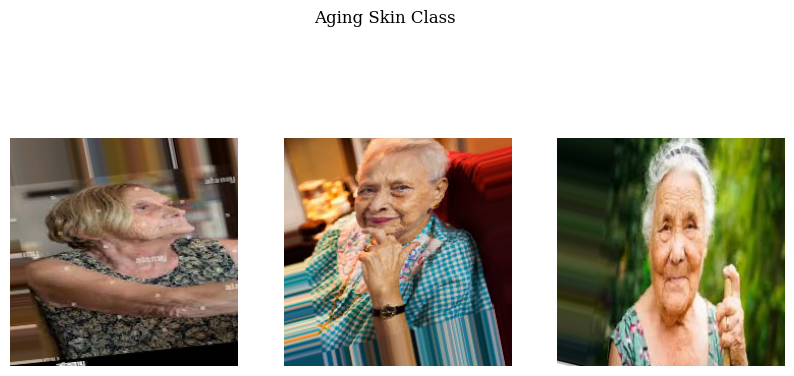

In [137]:
import matplotlib.pyplot as plt
import numpy as np

Aging_Skin_images = []  # List to store 'Aging Skin' class images
Aging_Skin_count = 0  # Counter for 'Aging Skin' class images

while Aging_Skin_count < 3:
    batch = train_generator.next()
    images = batch[0]
    labels = batch[1]

    for i in range(len(images)):
        img = images[i]
        label = labels[i]

        # Check if the label represents the 'Aging Skin' class
        if np.argmax(label) == class_indices['Aging Skin']:  # Assuming 'Aging Skin' class is index 0
            Aging_Skin_images.append(img)
            Aging_Skin_count += 1

        if Aging_Skin_count == 3:
            break

# Display 3 images from the 'Aging Skin' class
plt.figure(figsize=(10, 5))
plt.suptitle('Aging Skin Class', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(Aging_Skin_images[i])
    plt.axis('off')
plt.show()


# **Display 3 images from the Test Dataset (Aging Skin)**

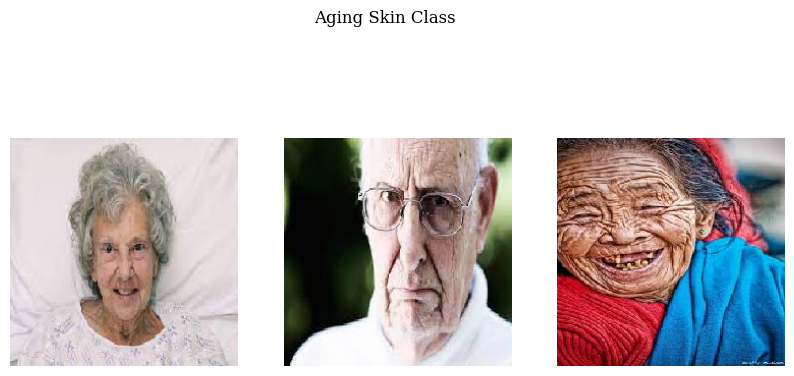

In [138]:
import matplotlib.pyplot as plt
import numpy as np

Aging_Skin_images = []  # List to store 'Aging Skin' class images
Aging_Skin_count = 0  # Counter for 'Aging Skin' class images

while Aging_Skin_count < 3:
    batch = test_generator.next()
    images = batch[0]
    labels = batch[1]

    for i in range(len(images)):
        img = images[i]
        label = labels[i]

        # Check if the label represents the 'Aging Skin' class
        if np.argmax(label) == class_indices['Aging Skin']:  # Assuming 'Aging Skin' class is index 0
            Aging_Skin_images.append(img)
            Aging_Skin_count += 1

        if Aging_Skin_count == 3:
            break

# Display 3 images from the 'Aging Skin' class
plt.figure(figsize=(10, 5))
plt.suptitle('Aging Skin Class', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(Aging_Skin_images[i])
    plt.axis('off')
plt.show()


# **Display 3 images from the Validation Dataset (Aging Skin)**

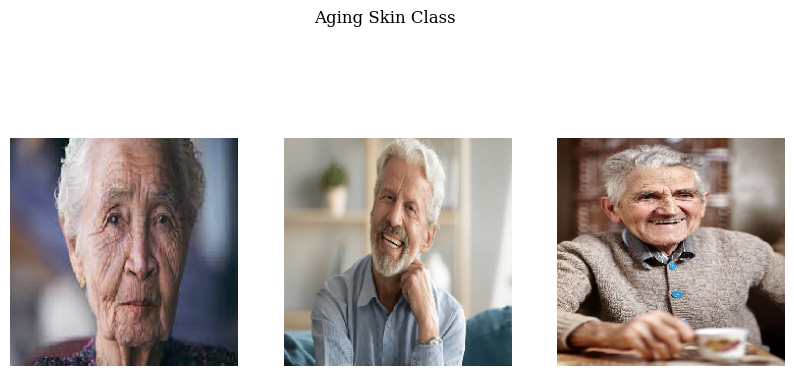

In [139]:
import matplotlib.pyplot as plt
import numpy as np

Aging_Skin_images = []  # List to store 'Aging Skin' class images
Aging_Skin_count = 0  # Counter for 'Aging Skin' class images

while Aging_Skin_count < 3:
    batch = validation_generator.next()
    images = batch[0]
    labels = batch[1]

    for i in range(len(images)):
        img = images[i]
        label = labels[i]

        # Check if the label represents the 'Aging Skin' class
        if np.argmax(label) == class_indices['Aging Skin']:  # Assuming 'Aging Skin' class is index 0
            Aging_Skin_images.append(img)
            Aging_Skin_count += 1

        if Aging_Skin_count == 3:
            break

# Display 3 images from the 'Aging Skin' class
plt.figure(figsize=(10, 5))
plt.suptitle('Aging Skin Class', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(Aging_Skin_images[i])
    plt.axis('off')
plt.show()


# **Display 3 images from the Train Dataset (Dry Skin class)**

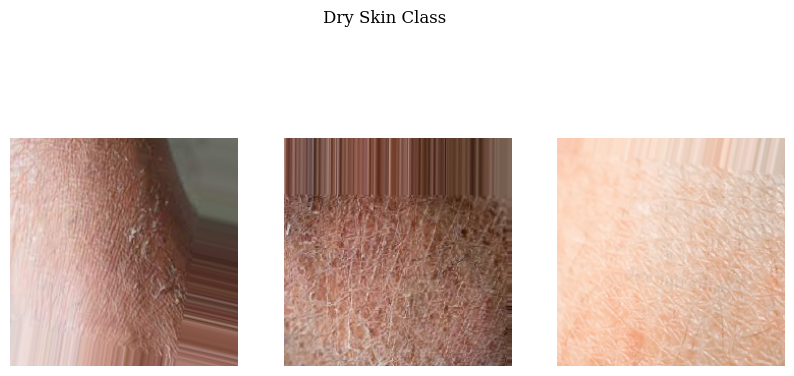

In [140]:
import matplotlib.pyplot as plt
import numpy as np

Dry_Skin_images = []  # List to store 'Dry Skin' class images
Dry_Skin_count = 0  # Counter for 'Dry Skin' class images

while Dry_Skin_count < 3:
    batch = train_generator.next()
    images = batch[0]
    labels = batch[1]

    for i in range(len(images)):
        img = images[i]
        label = labels[i]

        # Check if the label represents the 'Dry Skin' class
        if np.argmax(label) == class_indices['Dry Skin']:  # Assuming 'Dry Skin' class is index 1
            Dry_Skin_images.append(img)
            Dry_Skin_count += 1

        if Dry_Skin_count == 3:
            break

# Display 3 images from the 'Dry Skin' class
plt.figure(figsize=(10, 5))
plt.suptitle('Dry Skin Class', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(Dry_Skin_images[i])
    plt.axis('off')
plt.show()


# **Display 3 images from the Test Dataset (Dry Skin class)**

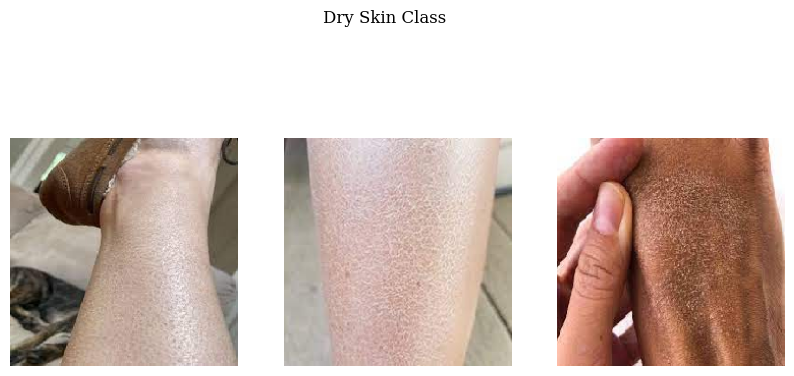

In [141]:
import matplotlib.pyplot as plt
import numpy as np

Dry_Skin_images = []  # List to store 'Dry Skin' class images
Dry_Skin_count = 0  # Counter for 'Dry Skin' class images

while Dry_Skin_count < 3:
    batch = test_generator.next()
    images = batch[0]
    labels = batch[1]

    for i in range(len(images)):
        img = images[i]
        label = labels[i]

        # Check if the label represents the 'Dry Skin' class
        if np.argmax(label) == class_indices['Dry Skin']:  # Assuming 'Dry Skin' class is index 1
            Dry_Skin_images.append(img)
            Dry_Skin_count += 1

        if Dry_Skin_count == 3:
            break

# Display 3 images from the 'Dry Skin' class
plt.figure(figsize=(10, 5))
plt.suptitle('Dry Skin Class', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(Dry_Skin_images[i])
    plt.axis('off')
plt.show()


# **Display 3 images from the Validation Dataset (Dry Skin class)**

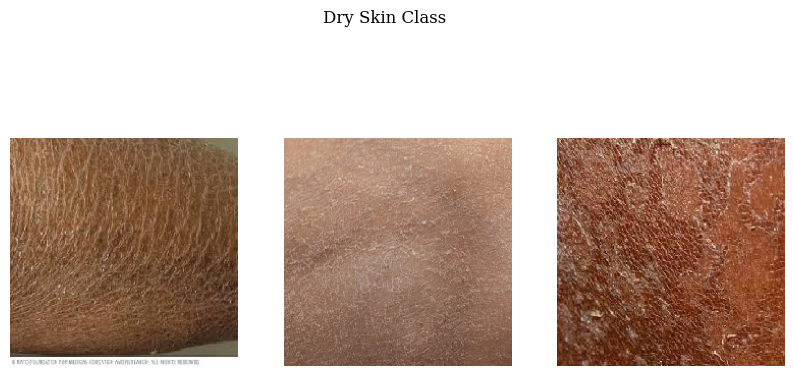

In [142]:
import matplotlib.pyplot as plt
import numpy as np

Dry_Skin_images = []  # List to store 'Dry Skin' class images
Dry_Skin_count = 0  # Counter for 'Dry Skin' class images

while Dry_Skin_count < 3:
    batch = validation_generator.next()
    images = batch[0]
    labels = batch[1]

    for i in range(len(images)):
        img = images[i]
        label = labels[i]

        # Check if the label represents the 'Dry Skin' class
        if np.argmax(label) == class_indices['Dry Skin']:  # Assuming 'Dry Skin' class is index 1
            Dry_Skin_images.append(img)
            Dry_Skin_count += 1

        if Dry_Skin_count == 3:
            break

# Display 3 images from the 'Dry Skin' class
plt.figure(figsize=(10, 5))
plt.suptitle('Dry Skin Class', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(Dry_Skin_images[i])
    plt.axis('off')
plt.show()


# **Display 3 images from the Train Dataset (Normal Skin class)**

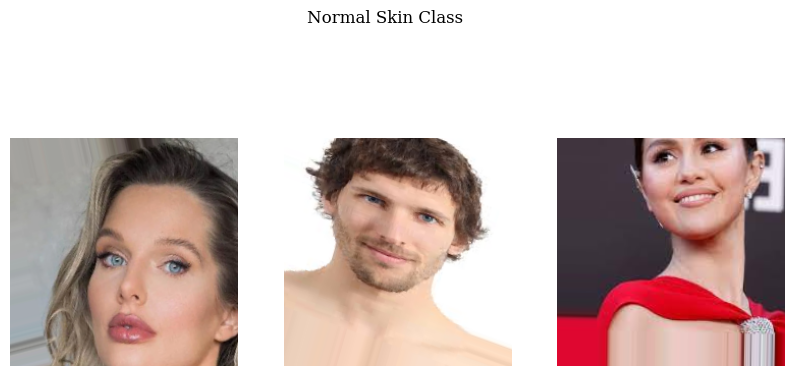

In [143]:
import matplotlib.pyplot as plt
import numpy as np

Normal_Skin_images = []  # List to store 'Normal Skin' class images
Normal_Skin_count = 0  # Counter for 'Normal Skin' class images

while Normal_Skin_count < 3:
    batch = train_generator.next()
    images = batch[0]
    labels = batch[1]

    for i in range(len(images)):
        img = images[i]
        label = labels[i]

        # Check if the label represents the 'Normal_Skin' class
        if np.argmax(label) == class_indices['Normal Skin']:  # Assuming 'Normal Skin' class is index 2
            Normal_Skin_images.append(img)
            Normal_Skin_count += 1

        if Normal_Skin_count == 3:
            break

# Display 3 images from the 'Normal_Skin' class
plt.figure(figsize=(10, 5))
plt.suptitle('Normal Skin Class', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(Normal_Skin_images[i])
    plt.axis('off')
plt.show()


# **Display 3 images from the Test Dataset (Normal Skin class)**

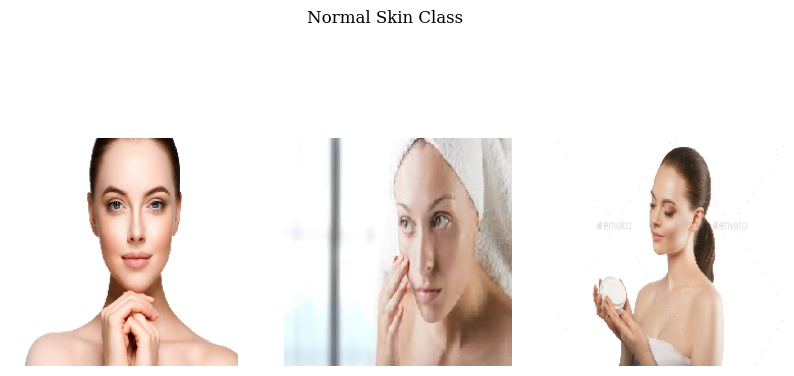

In [144]:
import matplotlib.pyplot as plt
import numpy as np

Normal_Skin_images = []  # List to store 'Normal Skin' class images
Normal_Skin_count = 0  # Counter for 'Normal Skin' class images

while Normal_Skin_count < 3:
    batch = test_generator.next()
    images = batch[0]
    labels = batch[1]

    for i in range(len(images)):
        img = images[i]
        label = labels[i]

        # Check if the label represents the 'Normal_Skin' class
        if np.argmax(label) == class_indices['Normal Skin']:  # Assuming 'Normal Skin' class is index 2
            Normal_Skin_images.append(img)
            Normal_Skin_count += 1

        if Normal_Skin_count == 3:
            break

# Display 3 images from the 'Normal_Skin' class
plt.figure(figsize=(10, 5))
plt.suptitle('Normal Skin Class', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(Normal_Skin_images[i])
    plt.axis('off')
plt.show()


# **Display 3 images from the Validation Dataset (Normal Skin class)**

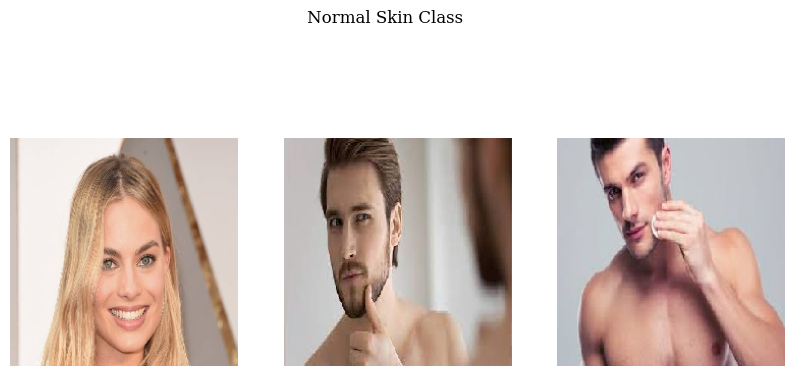

In [145]:
import matplotlib.pyplot as plt
import numpy as np

Normal_Skin_images = []  # List to store 'Normal Skin' class images
Normal_Skin_count = 0  # Counter for 'Normal Skin' class images

while Normal_Skin_count < 3:
    batch = validation_generator.next()
    images = batch[0]
    labels = batch[1]

    for i in range(len(images)):
        img = images[i]
        label = labels[i]

        # Check if the label represents the 'Normal_Skin' class
        if np.argmax(label) == class_indices['Normal Skin']:  # Assuming 'Normal Skin' class is index 2
            Normal_Skin_images.append(img)
            Normal_Skin_count += 1

        if Normal_Skin_count == 3:
            break

# Display 3 images from the 'Normal_Skin' class
plt.figure(figsize=(10, 5))
plt.suptitle('Normal Skin Class', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(Normal_Skin_images[i])
    plt.axis('off')
plt.show()


# **Display 3 images from the Train Dataset (Oily Skin class)**

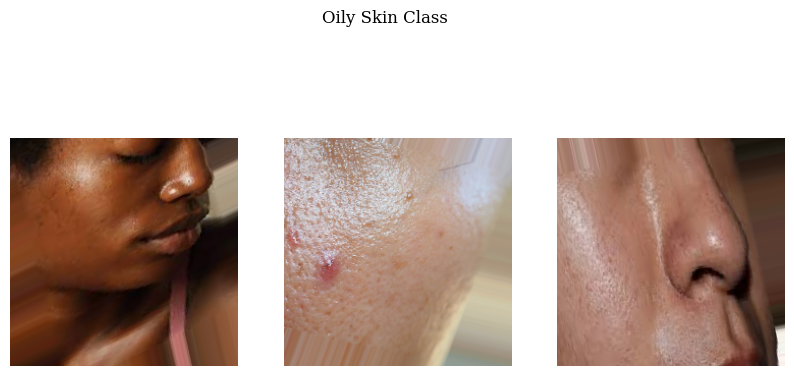

In [146]:
import matplotlib.pyplot as plt
import numpy as np

Oily_Skin_images = []  # List to store 'Oily Skin' class images
Oily_Skin_count = 0  # Counter for 'Oily Skin' class images

while Oily_Skin_count < 3:
    batch = train_generator.next()
    images = batch[0]
    labels = batch[1]

    for i in range(len(images)):
        img = images[i]
        label = labels[i]

        # Check if the label represents the 'Oily_Skin' class
        if np.argmax(label) == class_indices['Oily Skin']:  # Assuming 'Oily Skin' class is index 3
            Oily_Skin_images.append(img)
            Oily_Skin_count += 1

        if Oily_Skin_count == 3:
            break

# Display 3 images from the 'Oily_Skin' class
plt.figure(figsize=(10, 5))
plt.suptitle('Oily Skin Class', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(Oily_Skin_images[i])
    plt.axis('off')
plt.show()


# **Display 3 images from the Test Dataset (Oily Skin class)**

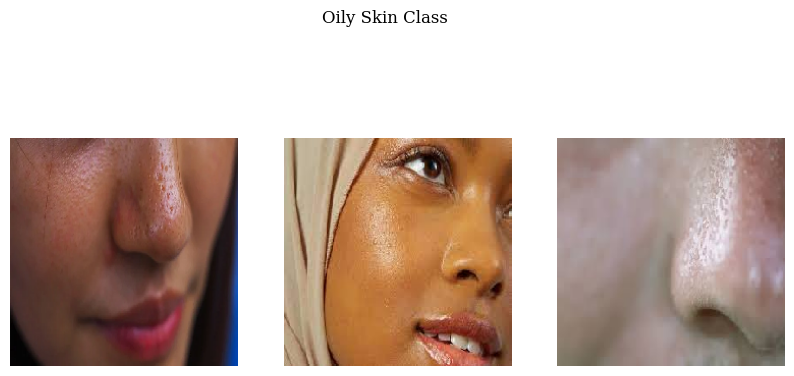

In [147]:
import matplotlib.pyplot as plt
import numpy as np

Oily_Skin_images = []  # List to store 'Oily Skin' class images
Oily_Skin_count = 0  # Counter for 'Oily Skin' class images

while Oily_Skin_count < 3:
    batch = test_generator.next()
    images = batch[0]
    labels = batch[1]

    for i in range(len(images)):
        img = images[i]
        label = labels[i]

        # Check if the label represents the 'Oily_Skin' class
        if np.argmax(label) == class_indices['Oily Skin']:  # Assuming 'Oily Skin' class is index 3
            Oily_Skin_images.append(img)
            Oily_Skin_count += 1

        if Oily_Skin_count == 3:
            break

# Display 3 images from the 'Oily_Skin' class
plt.figure(figsize=(10, 5))
plt.suptitle('Oily Skin Class', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(Oily_Skin_images[i])
    plt.axis('off')
plt.show()


# **Display 3 images from the Validation Dataset (Oily Skin class)**

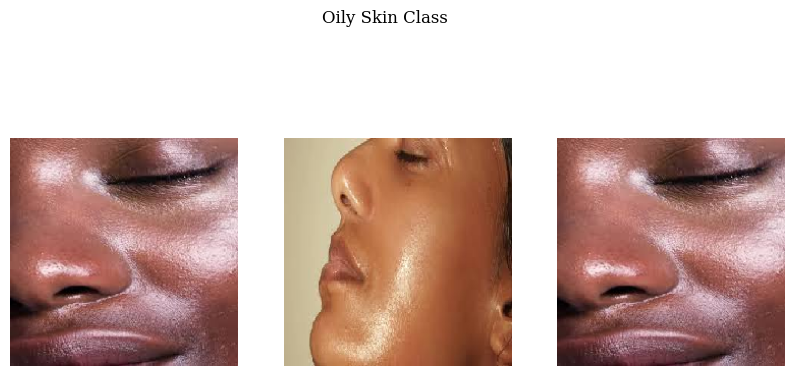

In [148]:
import matplotlib.pyplot as plt
import numpy as np

Oily_Skin_images = []  # List to store 'Oily Skin' class images
Oily_Skin_count = 0  # Counter for 'Oily Skin' class images

while Oily_Skin_count < 3:
    batch = validation_generator.next()
    images = batch[0]
    labels = batch[1]

    for i in range(len(images)):
        img = images[i]
        label = labels[i]

        # Check if the label represents the 'Oily_Skin' class
        if np.argmax(label) == class_indices['Oily Skin']:  # Assuming 'Oily Skin' class is index 3
            Oily_Skin_images.append(img)
            Oily_Skin_count += 1

        if Oily_Skin_count == 3:
            break

# Display 3 images from the 'Oily_Skin' class
plt.figure(figsize=(10, 5))
plt.suptitle('Oily Skin Class', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(Oily_Skin_images[i])
    plt.axis('off')
plt.show()


# **Display 3 images from the Train Dataset (Sensitive Skin class)**

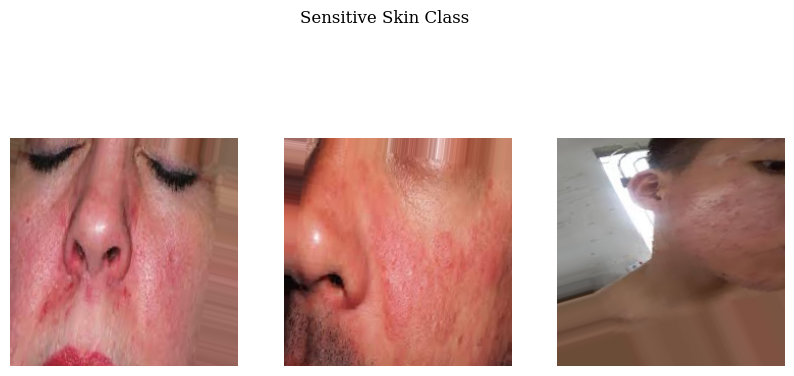

In [149]:
import matplotlib.pyplot as plt
import numpy as np

Sensitive_Skin_images = []  # List to store 'Sensitive Skin' class images
Sensitive_Skin_count = 0  # Counter for 'Sensitive Skin' class images

while Sensitive_Skin_count < 3:
    batch = train_generator.next()
    images = batch[0]
    labels = batch[1]

    for i in range(len(images)):
        img = images[i]
        label = labels[i]

        # Check if the label represents the 'Sensitive_Skin' class
        if np.argmax(label) == class_indices['Sensitive Skin']:  # Assuming 'Sensitive Skin' class is index 4
            Sensitive_Skin_images.append(img)
            Sensitive_Skin_count += 1

        if Sensitive_Skin_count == 3:
            break

# Display 3 images from the 'Sensitive_Skin' class
plt.figure(figsize=(10, 5))
plt.suptitle('Sensitive Skin Class', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(Sensitive_Skin_images[i])
    plt.axis('off')
plt.show()


# **Display 3 images from the Test Dataset (Sensitive Skin class)**

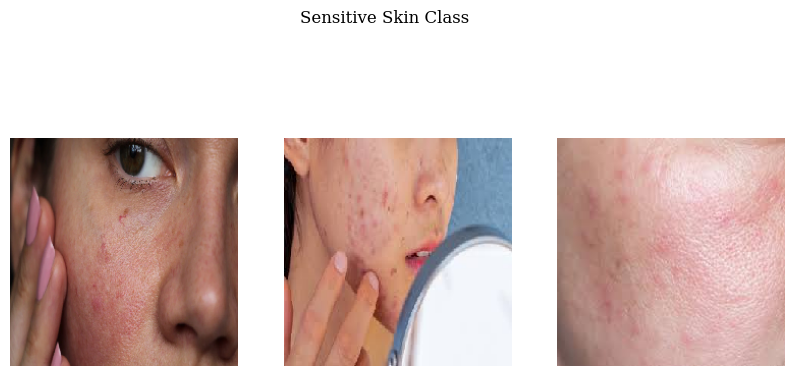

In [150]:
import matplotlib.pyplot as plt
import numpy as np

Sensitive_Skin_images = []  # List to store 'Sensitive Skin' class images
Sensitive_Skin_count = 0  # Counter for 'Sensitive Skin' class images

while Sensitive_Skin_count < 3:
    batch = test_generator.next()
    images = batch[0]
    labels = batch[1]

    for i in range(len(images)):
        img = images[i]
        label = labels[i]

        # Check if the label represents the 'Sensitive_Skin' class
        if np.argmax(label) == class_indices['Sensitive Skin']:  # Assuming 'Sensitive Skin' class is index 4
            Sensitive_Skin_images.append(img)
            Sensitive_Skin_count += 1

        if Sensitive_Skin_count == 3:
            break

# Display 3 images from the 'Sensitive_Skin' class
plt.figure(figsize=(10, 5))
plt.suptitle('Sensitive Skin Class', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(Sensitive_Skin_images[i])
    plt.axis('off')
plt.show()


# **Display 3 images from the Validation Dataset (Sensitive Skin class)**

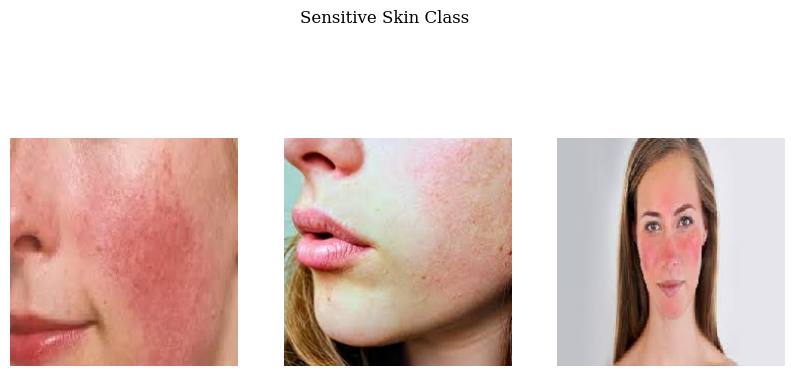

In [151]:
import matplotlib.pyplot as plt
import numpy as np

Sensitive_Skin_images = []  # List to store 'Sensitive Skin' class images
Sensitive_Skin_count = 0  # Counter for 'Sensitive Skin' class images

while Sensitive_Skin_count < 3:
    batch = validation_generator.next()
    images = batch[0]
    labels = batch[1]

    for i in range(len(images)):
        img = images[i]
        label = labels[i]

        # Check if the label represents the 'Sensitive_Skin' class
        if np.argmax(label) == class_indices['Sensitive Skin']:  # Assuming 'Sensitive Skin' class is index 4
            Sensitive_Skin_images.append(img)
            Sensitive_Skin_count += 1

        if Sensitive_Skin_count == 3:
            break

# Display 3 images from the 'Sensitive_Skin' class
plt.figure(figsize=(10, 5))
plt.suptitle('Sensitive Skin Class', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(Sensitive_Skin_images[i])
    plt.axis('off')
plt.show()


# **Check for GPU availability**

In [152]:
# Check for GPU availability
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

# Set TensorFlow to use the GPU device
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
    print("GPU device configured")
else:
    print("No GPU device found")

GPU is available
GPU device configured


# **InceptionV3 for Feature Extractor**

In [167]:
BATCH_SIZE = 8
IMG_WIDTH = 224
IMG_HEIGHT = 224

def create_model(summary=True):
    # apply transfer learning
    new_input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    model = InceptionV3(weights='imagenet', include_top=False, input_tensor=new_input)
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    output = Dense(5, activation='softmax')(flat1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    if summary:
        print(model.summary())
    return model

model_dir = '/content/drive/MyDrive/Skin_Type_Classification_Model/model'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

checkpoint_path = model_dir + '/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback to save the entire best model
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,  # Save the entire model
    monitor='val_loss',       # Choose the validation metric to monitor
    save_best_only=True,
    mode='min',               # Save the model when the monitored quantity (val_loss) has stopped decreasing
    verbose=1
)

In [168]:
model = create_model()

87910968/87910968 [==============================] - 5s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_6[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)   

# **Training Start Here**

In [169]:
history = model.fit(
    train_generator,
    steps_per_epoch=20,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=5,
    callbacks=[cp_callback]
)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 5.1489 - accuracy: 0.4500
Epoch 1: val_loss improved from inf to 585.96680, saving model to /content/drive/MyDrive/Skin_Type_Classification_Model/model/cp.ckpt
20/20 [==============================] - 79s 2s/step - loss: 5.1489 - accuracy: 0.4500 - val_loss: 585.9668 - val_accuracy: 0.2000
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 5.3945 - accuracy: 0.4528
Epoch 2: val_loss did not improve from 585.96680
20/20 [==============================] - 9s 454ms/step - loss: 5.3945 - accuracy: 0.4528 - val_loss: 714.6641 - val_accuracy: 0.2000
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 2.5459 - accuracy: 0.3875
Epoch 3: val_loss did not improve from 585.96680
20/20 [==============================] - 6s 274ms/step - loss: 2.5459 - accuracy: 0.3875 - val_loss: 4363.2202 - val_accuracy: 0.1750
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 2.1627 - accurac

# **Saving the model**

In [170]:
# Save the model in the recommended .keras format
model.save('/content/drive/MyDrive/Skin_Type_Classification_Model/my_model.keras')  # Save with .keras extension

# **Accuracy and loss graph of training and validation**

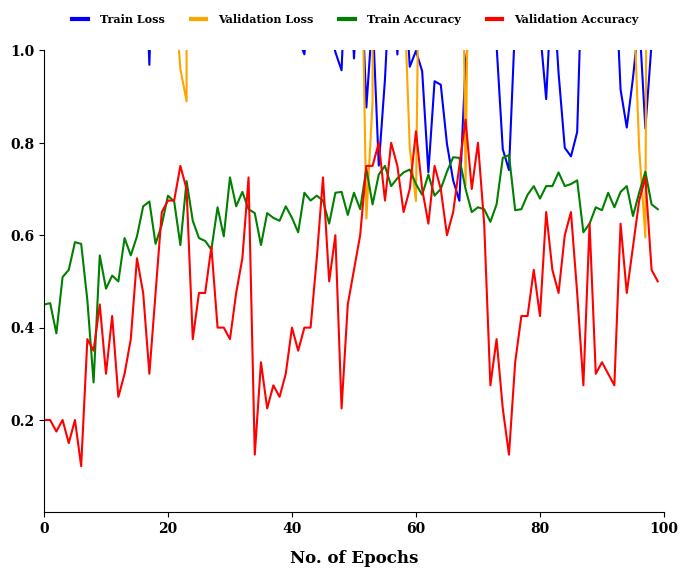

In [171]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerLine2D
import numpy as np

# Plot training & validation loss values
plt.figure(figsize=(8, 6))

# Plot Loss
train_loss, = plt.plot(history.history['loss'], label='Train Loss', color='blue')
val_loss, = plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
train_accuracy, = plt.plot(history.history['accuracy'], label='Train Accuracy',  color='green')
val_accuracy, = plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')

# Set x-axis label with specified font properties
plt.xlabel('No. of Epochs', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})

# Set x-axis ticks font properties
plt.xticks(np.linspace(0, len(history.history['loss']), num=6), fontname='Serif', weight='bold')

# Set y-axis ticks font properties
plt.yticks(np.linspace(0.2, 1, num=5), fontname='Serif', weight='bold')

# Set the x-axis and y-axis limits
plt.xlim(0, len(history.history['loss']))
plt.ylim(0, 1)

# Define custom legend lines with desired line properties
legend_lines = [
    Line2D([0], [0], color='blue', lw=3),          # Train Loss
    Line2D([0], [0], color='orange', lw=3),       # Validation Loss
    Line2D([0], [0], color='green', lw=3),        # Train Accuracy
    Line2D([0], [0], color='red', lw=3)           # Validation Accuracy
]

# Place legend outside the graph by adjusting bbox_to_anchor and specifying it to be outside the axes
plt.legend(legend_lines, ['Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy'],
           loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4,
           prop={'family': 'Serif', 'weight': 'bold', 'size': 8}, frameon=False,
           handler_map={Line2D: HandlerLine2D(numpoints=5)})

# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


# **Testing Start Here**

In [172]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

9/9 [==============================] - 2s 290ms/step - loss: 3.1897 - accuracy: 0.5217
Test Accuracy: 0.52173912525177


In [173]:
# Predict labels for the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Get the index of the highest probability class
true_classes = test_generator.classes

# Display some of the predicted and true classes
print("Predicted Classes:", predicted_classes[:10])  # Display first 10 predicted classes
print("True Classes:", true_classes[:10])  # Display first 10 true classes


9/9 [==============================] - 2s 93ms/step
Predicted Classes: [0 0 0 0 0 0 0 0 0 0]
True Classes: [0 0 0 0 0 0 0 0 0 0]


# **Classification Report**

In [174]:
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes))


Classification Report:
              precision    recall  f1-score   support

           0       0.42      1.00      0.59        15
           1       0.71      0.86      0.77        14
           2       1.00      0.07      0.12        15
           3       0.33      0.10      0.15        10
           4       0.58      0.47      0.52        15

    accuracy                           0.52        69
   macro avg       0.61      0.50      0.43        69
weighted avg       0.63      0.52      0.45        69



# **Evaluation Metircs**

In [175]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, log_loss, jaccard_score
print(f"Accuracy: {accuracy_score(true_classes, predicted_classes)}")
print(f"Precision: {precision_score(true_classes, predicted_classes, average='weighted')}")
print(f"Recall: {recall_score(true_classes, predicted_classes, average='weighted')}")
print(f"F1 Score: {f1_score(true_classes, predicted_classes, average='weighted')}")
print(f"Jaccard Score: {jaccard_score(true_classes, predicted_classes, average='weighted')}")

Accuracy: 0.5217391304347826
Precision: 0.6263142938334755
Recall: 0.5217391304347826
F1 Score: 0.44715186094816495
Jaccard Score: 0.3213831680650902


# **Confusion Matrix**

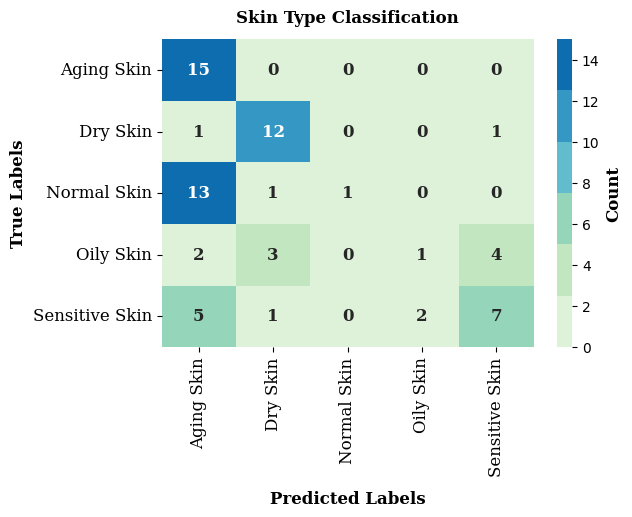

In [176]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
# Define the custom palette
custom_palette = sns.color_palette(palette='GnBu')# Modify the number based on number of classes in the dataset
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,
                      xticklabels=['Aging Skin', 'Dry Skin','Normal Skin','Oily Skin','Sensitive Skin'],
                      yticklabels=['Aging Skin', 'Dry Skin','Normal Skin','Oily Skin','Sensitive Skin'],annot_kws={"family": "Serif",'weight': 'bold', 'size': 12})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font)
heatmap.set_ylabel('True Labels', fontdict=font)
heatmap.set_title('Skin Type Classification', fontdict=font, pad=12)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.set_label('Count', fontdict=font)
cbar.ax.tick_params(labelsize=10)
# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space
plt.show()


# **Checking model predictions for random images from test dataset**

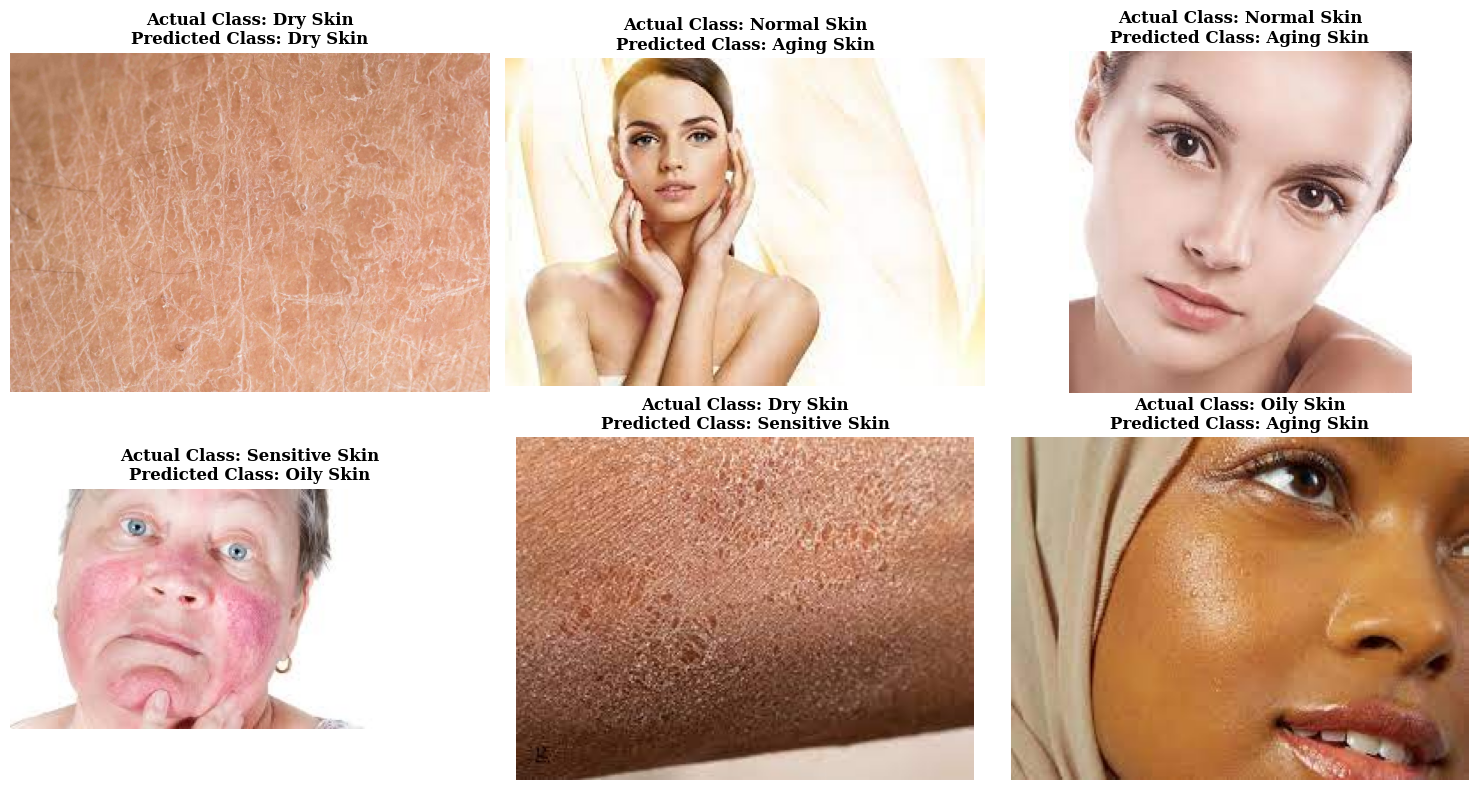

In [177]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# Assuming true_classes and predicted_classes contain the class indices (0 to 4)
# Replace the class names accordingly
class_names = ['Aging Skin', 'Dry Skin', 'Normal Skin', 'Oily Skin', 'Sensitive Skin']

# Get random indices for six images
random_indices = random.sample(range(len(true_classes)), 6)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices, 1):
    # Load the image
    img_path = test_generator.filepaths[idx]
    img = Image.open(img_path)

    # Display the image
    plt.subplot(2, 3, i)
    plt.imshow(img)
    plt.axis('off')

    # Display the true and predicted labels
    true_label = class_names[true_classes[idx]]
    predicted_label = class_names[predicted_classes[idx]]

    plt.title(f"Actual Class: {true_label}\nPredicted Class: {predicted_label}", fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})

plt.tight_layout()
plt.show()
